In [ ]:
!gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
!unzip data.zip
!ls

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR
From (redirected): https://drive.google.com/uc?id=1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR&confirm=t&uuid=ef29ec91-3580-4648-a18c-2cc728b32cf8
To: /content/data.zip
100% 372M/372M [00:11<00:00, 32.1MB/s]
Archive:  data.zip
   creating: timit_11/
  inflating: timit_11/train_11.npy   
  inflating: timit_11/test_11.npy    
  inflating: timit_11/train_label_11.npy  
data.zip  sample_data  timit_11


In [ ]:
import numpy as np

print('Loading data ...')

data_root='./timit_11/'
train = np.load(data_root + 'train_11.npy')
train_label = np.load(data_root + 'train_label_11.npy')
test = np.load(data_root + 'test_11.npy')

print('Size of training data: {}'.format(train.shape))
print('Size of testing data: {}'.format(test.shape))

Loading data ...
Size of training data: (1229932, 429)
Size of testing data: (451552, 429)


In [ ]:
import torch
from torch.utils.data import Dataset

class TIMITDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.int64)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

Split the labeled data into a training set and a validation set, you can modify the variable VAL_RATIO to change the ratio of validation data.

In [ ]:
VAL_RATIO = 0.2

percent = int(train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (983945, 429)
Size of validation set: (245987, 429)


In [ ]:
#Create a data loader from the dataset, feel free to tweak the variable BATCH_SIZE here.
BATCH_SIZE = 64

from torch.utils.data import DataLoader

train_set = TIMITDataset(train_x, train_y)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

Cleanup the unneeded variables to save memory.

**notes: To use these variables later, then remove this block or clean up unneeded variables later
the data size is quite huge, so be aware of memory usage in colab**

In [ ]:
import gc

del train, train_label, train_x, train_y, val_x, val_y
gc.collect()

0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # Define the linear layers
        self.layer1 = nn.Linear(429, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 128)
        self.out = nn.Linear(128, 39)

        # Define BatchNorm layers for each layer output
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(128)

        # Define Dropout layers
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)

        self.act_fn = nn.Sigmoid()

    def forward(self, x):
        # x = self.layer1(x)
        # x = self.act_fn(x)

        # x = self.layer2(x)
        # x = self.act_fn(x)

        # x = self.layer3(x)
        # x = self.act_fn(x)

        # x = self.out(x)
        # Pass data through layer 1 with BatchNorm and Dropout
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.act_fn(x)
        x = self.dropout1(x)

        # Pass data through layer 2 with BatchNorm and Dropout
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act_fn(x)
        x = self.dropout2(x)

        # Pass data through layer 3 with BatchNorm and Dropout
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.act_fn(x)
        x = self.dropout3(x)

        # Output layer
        x = self.out(x)

        return x

In [ ]:
class DeeperClassifier(nn.Module):
    def __init__(self):
        super(DeeperClassifier, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(429, 1024),
            nn.Linear(1024, 1024),
            nn.Linear(1024, 1024),
            nn.Linear(1024, 1024),
            nn.Linear(1024, 1024),
            nn.Linear(1024, 1024)
        ])
        self.bns = nn.ModuleList([nn.BatchNorm1d(1024) for _ in range(6)])
        self.dropout = nn.Dropout(0.25)
        self.out = nn.Linear(1024, 39)

    def forward(self, x):
        for i in range(6):
            x = self.layers[i](x)
            x = self.bns[i](x)
            # x = F.relu(x)
            # use sigmoid instead of relu
            x = F.sigmoid(x)
            x = self.dropout(x)
        x = self.out(x)
        return x

In [ ]:
class ShallowerClassifier(nn.Module):
    def __init__(self):
        super(ShallowerClassifier, self).__init__()
        # Initialize fewer layers with more neurons
        self.layer1 = nn.Linear(429, 1700)
        self.layer2 = nn.Linear(1700, 1700)
        self.out = nn.Linear(1700, 39)

        self.bn1 = nn.BatchNorm1d(1700)
        self.bn2 = nn.BatchNorm1d(1700)
        # modify dropout to 0.25
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.out(x)
        return x

In [ ]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Fix random seeds for reproducibility.
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Feel free to change the training parameters here.

In [ ]:
# fix random seed for reproducibility
same_seeds(0)

# get device
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 20
learning_rate = 0.0001

# the path where checkpoint saved
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
# model = Classifier().to(device)
model = DeeperClassifier().to(device)
# model = ShallowerClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cuda


In [ ]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_learning_curve(loss_record: dict, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 3.)
    plt.xlabel('Training steps')
    plt.ylabel('CrossEntropyLoss loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(validation_set, model, device):
    ''' Plot classification accuracy using a confusion matrix '''
    model.eval()
    all_preds, all_targets = [], []
    # Collect all predictions and targets
    for x, y in validation_set:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            outputs = model(x)
            _, pred = torch.max(outputs, 1)  # Get the index of the max log-probability
            all_preds.extend(pred.detach().cpu().numpy())
            all_targets.extend(y.detach().cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    # Plotting using seaborn or matplotlib
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# start training

loss_record = {'train': [], 'dev': []}
acc_record = {'train': [], 'dev': []}

best_acc = 0.0
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    num_train_samples = 0
    num_val_samples = 0

    # training
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        # print("train_pred: ", train_pred)
        batch_loss.backward()
        optimizer.step()

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()
        num_train_samples += labels.size(0)

    # Store training loss and accuracy
    loss_record['train'].append(train_loss / len(train_loader))
    acc_record['train'].append(train_acc / num_train_samples)

    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels)
                _, val_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

                val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
                val_loss += batch_loss.item()
                num_val_samples += labels.size(0)
            # Store validation loss and accuracy
            loss_record['dev'].append(val_loss / len(val_loader))
            acc_record['dev'].append(val_acc / num_val_samples)

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc / num_train_samples, train_loss / len(train_loader),
            val_acc / num_val_samples, val_loss / len(val_loader)
        ))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
              best_acc = val_acc
              torch.save(model.state_dict(), model_path)
              print('saving model with acc {:.3f}'.format(best_acc / num_val_samples))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')

[001/020] Train Acc: 0.416317 Loss: 1.964163 | Val Acc: 0.494364 Loss: 1.655335
saving model with acc 0.494
[002/020] Train Acc: 0.464800 Loss: 1.775907 | Val Acc: 0.534935 Loss: 1.520232
saving model with acc 0.535
[003/020] Train Acc: 0.497791 Loss: 1.661134 | Val Acc: 0.577575 Loss: 1.384919
saving model with acc 0.578
[004/020] Train Acc: 0.527684 Loss: 1.554582 | Val Acc: 0.612069 Loss: 1.269793
saving model with acc 0.612
[005/020] Train Acc: 0.552218 Loss: 1.466526 | Val Acc: 0.633635 Loss: 1.188204
saving model with acc 0.634
[006/020] Train Acc: 0.571070 Loss: 1.396420 | Val Acc: 0.650892 Loss: 1.124950
saving model with acc 0.651
[007/020] Train Acc: 0.586835 Loss: 1.338701 | Val Acc: 0.662982 Loss: 1.079281
saving model with acc 0.663
[008/020] Train Acc: 0.599768 Loss: 1.291609 | Val Acc: 0.672340 Loss: 1.040693
saving model with acc 0.672
[009/020] Train Acc: 0.611126 Loss: 1.250518 | Val Acc: 0.680077 Loss: 1.012039
saving model with acc 0.680
[010/020] Train Acc: 0.61989

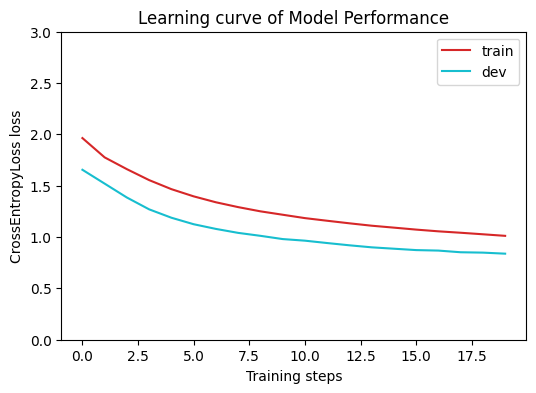

In [ ]:
plot_learning_curve(loss_record, title='Model Performance')

**Testing**

Create a testing dataset, and load model from the saved checkpoint.

In [ ]:
# create testing dataset
test_set = TIMITDataset(test, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = DeeperClassifier().to(device)
# model = ShallowerClassifier().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
predict = []
model.eval() # set the model to evaluation mode
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

        for y in test_pred.cpu().numpy():
            predict.append(y)

Write prediction to a CSV file.

After finish running this block, download the file prediction.csv from the files section on the left-hand side and submit it to Kaggle.

In [ ]:
with open('prediction.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(predict):
        f.write('{},{}\n'.format(i, y))